The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


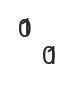

In [8]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_nested_feature_importance, plot_feature_importance, get_metrics
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.bootstrap import get_pval, plot_pval
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [12]:
def get_fold(args_txtfile):
    """
    Quick & dirty code that I'm sure won't bite me in the ass later.
    ## TODO: Actually, it's as dirty but slightly better to read the args txt file and parse the kcv from there
    Args:
        string:
        filename:

    Returns:
        Gets the kcv fold
    """
    # return int(string.split('_' + filename)[0].split('_f')[1])
    with open(args_txtfile, 'r') as f:
        return int([x.replace('fold: ','').replace('\n','') for x in f.readlines() if x.startswith('fold:')][0])


def get_hps(filename):
    keys = ['encoding', 'pad', 'main_nh', 'std', 'main_bn', 'main_drop',
            'window_size', 'extra_nh', 'extra_bn', 'extra_drop', 'lr', 'wd', 'batch_size',
            'features']
    dtypes = {'encoding': str,
              'pad': int,
              'std': bool,
              'main_nh': int,
              'main_bn': bool,
              'main_drop': float,
              'window_size': int,
              'extra_nh': int,
              'extra_bn': bool,
              'extra_drop': float,
              'lr': float,
              'wd': float,
              'batch_size': int,
              'features': str}
    params = [x.replace('xx', '-').replace('zp', '0.').replace('XX', '_').replace('/','') for x in filename.split('_')]
    params = [x.capitalize() if x in ['true', 'false'] else x for x in params]
    return {k: dtypes[k](v) for k, v in zip(keys, params)}


In [10]:
from os import path
maindir = '/Users/riwa/Documents/code/PyNNalign/output/2306xx_hptune/'
fold_dir = 'BL50LO_0_10_true_false_zp0_5_10_false_zp0_1exx3_0_128_ELXXrankXXmut-icoreXXblsmXXmutXXscore/'
subdirs = [x for x in os.listdir(maindir+fold_dir) if path.isdir(path.join(maindir+fold_dir, x))]

In [62]:
subdirs = [x for x in os.listdir(maindir+fold_dir) if path.isdir(path.join(maindir+fold_dir, x))]
valid_preds, test_preds = [], []
hyperparams = get_hps(fold_dir)
per_fold = []
for subdir in subdirs:
    fullpath = maindir+fold_dir+subdir+'/'
    args_txtfile = next(filter(lambda x: 'args' in x and x.endswith('.txt'), os.listdir(fullpath)))
    fold = get_fold(args_txtfile=fullpath+args_txtfile)
    # Appending to do mean/concat things at the end
    valid = pd.read_csv(f"{fullpath}{next(filter(lambda x: 'valid_pred' in x, os.listdir(fullpath)))}").assign(fold=fold)
    valid_preds.append(valid)
    test = pd.read_csv(f"{fullpath}{next(filter(lambda x: 'test_pred' in x, os.listdir(fullpath)))}").assign(fold=fold)
    test_preds.append(test)
    valid_metrics = pd.DataFrame(get_metrics(valid[tcol], valid[pcol], threshold=0.5), index=[fold])
    valid_metrics.columns = [f'valid_{x}' for x in valid_metrics.columns]
    test_metrics = pd.DataFrame(get_metrics(test[tcol], test[pcol], threshold=0.5), index=[fold])
    test_metrics.columns = [f'test_{x}' for x in test_metrics.columns]
    per_fold.append(pd.concat([valid_metrics, test_metrics], axis=1).assign(fold=fold))
per_fold, valid_preds, test_preds = pd.concat(per_fold), pd.concat(valid_preds), pd.concat(test_preds)

In [64]:
per_fold = per_fold.sort_values('fold').append(per_fold.mean(axis=0), ignore_index=True).replace(to_replace={'fold':4.5}, value='mean')

In [65]:
per_fold

,valid_auc,valid_auc_01,valid_precision,valid_accuracy,valid_AP,test_auc,test_auc_01,test_precision,test_accuracy,test_AP,fold
0,0.71620,0.53310,0.4706,0.78820,0.36610,0.66140,0.52080,0.02760,0.90870,0.0295,0.0
1,0.65780,0.53200,0.3733,0.71990,0.34710,0.57350,0.51710,0.02140,0.76980,0.0216,1.0
2,0.57560,0.50830,0.2500,0.79030,0.22370,0.58830,0.55430,0.03640,0.89020,0.0293,2.0
3,0.66610,0.54340,0.3846,0.74070,0.35250,0.56650,0.50470,0.01510,0.81780,0.0193,3.0
4,0.62540,0.55270,0.5455,0.79310,0.35360,0.59760,0.53220,0.03390,0.96420,0.0248,4.0
5,0.66550,0.53460,0.2754,0.71090,0.29700,0.62880,0.48690,0.02300,0.75420,0.0207,5.0
6,0.61210,0.56330,0.5238,0.77490,0.37420,0.63340,0.52970,0.03200,0.88730,0.0253,6.0
7,0.63730,0.52060,0.3478,0.74340,0.35050,0.67100,0.54190,0.02600,0.86330,0.0347,7.0
8,0.67140,0.57040,0.2923,0.63250,0.38790,0.59950,0.51010,0.01990,0.50260,0.0217,8.0
9,0.67500,0.54240,0.3117,0.68920,0.32530,0.57560,0.51800,0.02030,0.68740,0.0241,9.0


In [77]:
test_preds.groupby(['HLA','target','mutant']).agg(mean_pred=('pred','mean')).reset_index()

,HLA,target,mutant,mean_pred
0,HLA-A0101,0,ALEVLQSIPY,0.161868
1,HLA-A0101,0,ASNSCFIRY,0.111674
2,HLA-A0101,0,ATALLEYLEY,0.524123
3,HLA-A0101,0,AVDFSHLYV,0.125287
4,HLA-A0101,0,CATCAENFY,0.001148
...,...,...,...,...
2701,HLA-C1502,0,RSLCRGKGKI,0.007161
2702,HLA-C1502,0,RVARLGYKDV,0.001809
2703,HLA-C1502,0,SALVRVLVL,0.245491
2704,HLA-C1502,0,VSLVVKMFEL,0.129186


In [78]:
get_metrics(test_preds[tcol], test_preds[pcol])

{'auc': 0.5887,
 'auc_01': 0.5173,
 'precision': 0.0226,
 'accuracy': 0.8045,
 'AP': 0.021}

In [93]:
valid_preds, test_preds = [], []
hyperparams = get_hps(fold_dir)
per_fold = []
for subdir in subdirs:
    fullpath = maindir+fold_dir+subdir+'/'
    args_txtfile = next(filter(lambda x: 'args' in x and x.endswith('.txt'), os.listdir(fullpath)))
    fold = get_fold(args_txtfile=fullpath+args_txtfile)
    # Appending to do mean/concat things at the end
    valid = pd.read_csv(f"{fullpath}{next(filter(lambda x: 'valid_pred' in x, os.listdir(fullpath)))}").assign(fold=fold)
    valid_preds.append(valid)
    test = pd.read_csv(f"{fullpath}{next(filter(lambda x: 'test_pred' in x, os.listdir(fullpath)))}").assign(fold=fold)
    test_preds.append(test)
    valid_metrics = pd.DataFrame(get_metrics(valid[tcol], valid[pcol], threshold=0.5), index=[fold])
    valid_metrics.columns = [f'valid_{x}' for x in valid_metrics.columns]
    test_metrics = pd.DataFrame(get_metrics(test[tcol], test[pcol], threshold=0.5), index=[fold])
    test_metrics.columns = [f'test_{x}' for x in test_metrics.columns]
    per_fold.append(pd.concat([valid_metrics, test_metrics], axis=1).assign(fold=fold))
per_fold, valid_preds, test_preds = pd.concat(per_fold), pd.concat(valid_preds), pd.concat(test_preds)

    # Adding HP
# per_fold = pd.concat([per_fold, pd.concat([pd.DataFrame(hyperparams, index=[i]) for i in range(len(per_fold))])],
#                          axis=1)


In [94]:
per_fold

,valid_auc,valid_auc_01,valid_precision,valid_accuracy,valid_AP,test_auc,test_auc_01,test_precision,test_accuracy,test_AP,fold
2,0.5756,0.5083,0.2500,0.7903,0.2237,0.5883,0.5543,0.0364,0.8902,0.0293,2
8,0.6714,0.5704,0.2923,0.6325,0.3879,0.5995,0.5101,0.0199,0.5026,0.0217,8
9,0.6750,0.5424,0.3117,0.6892,0.3253,0.5756,0.5180,0.0203,0.6874,0.0241,9
4,0.6254,0.5527,0.5455,0.7931,0.3536,0.5976,0.5322,0.0339,0.9642,0.0248,4
5,0.6655,0.5346,0.2754,0.7109,0.2970,0.6288,0.4869,0.0230,0.7542,0.0207,5
7,0.6373,0.5206,0.3478,0.7434,0.3505,0.6710,0.5419,0.0260,0.8633,0.0347,7
0,0.7162,0.5331,0.4706,0.7882,0.3661,0.6614,0.5208,0.0276,0.9087,0.0295,0
6,0.6121,0.5633,0.5238,0.7749,0.3742,0.6334,0.5297,0.0320,0.8873,0.0253,6
3,0.6661,0.5434,0.3846,0.7407,0.3525,0.5665,0.5047,0.0151,0.8178,0.0193,3
1,0.6578,0.5320,0.3733,0.7199,0.3471,0.5735,0.5171,0.0214,0.7698,0.0216,1


,valid_auc,valid_auc_01,valid_precision,valid_accuracy,valid_AP,test_auc,test_auc_01,test_precision,test_accuracy,test_AP,fold
0,0.65024,0.54008,0.3775,0.73831,0.33779,0.60956,0.52157,0.02556,0.80455,0.0251,4.5


In [102]:
# Adding mean perf
pd.concat([per_fold.sort_values('fold'), pd.DataFrame(per_fold.mean(axis=0)).T], axis=0, ignore_index=True).replace(
        to_replace={'fold': 4.5}, value='average')

,valid_auc,valid_auc_01,valid_precision,valid_accuracy,valid_AP,test_auc,test_auc_01,test_precision,test_accuracy,test_AP,fold
0,0.71620,0.53310,0.4706,0.78820,0.36610,0.66140,0.52080,0.02760,0.90870,0.0295,0.0
1,0.65780,0.53200,0.3733,0.71990,0.34710,0.57350,0.51710,0.02140,0.76980,0.0216,1.0
2,0.57560,0.50830,0.2500,0.79030,0.22370,0.58830,0.55430,0.03640,0.89020,0.0293,2.0
3,0.66610,0.54340,0.3846,0.74070,0.35250,0.56650,0.50470,0.01510,0.81780,0.0193,3.0
4,0.62540,0.55270,0.5455,0.79310,0.35360,0.59760,0.53220,0.03390,0.96420,0.0248,4.0
5,0.66550,0.53460,0.2754,0.71090,0.29700,0.62880,0.48690,0.02300,0.75420,0.0207,5.0
6,0.61210,0.56330,0.5238,0.77490,0.37420,0.63340,0.52970,0.03200,0.88730,0.0253,6.0
7,0.63730,0.52060,0.3478,0.74340,0.35050,0.67100,0.54190,0.02600,0.86330,0.0347,7.0
8,0.67140,0.57040,0.2923,0.63250,0.38790,0.59950,0.51010,0.01990,0.50260,0.0217,8.0
9,0.67500,0.54240,0.3117,0.68920,0.32530,0.57560,0.51800,0.02030,0.68740,0.0241,9.0


In [81]:
pd.concat([total_valid_metrics, test_mean_metrics, test_concat_metrics, pd.DataFrame(hyperparams, index=[0])], axis=1)

,total_valid_auc,total_valid_auc_01,total_valid_precision,total_valid_accuracy,total_valid_AP,test_mean_auc,test_mean_auc_01,test_mean_precision,test_mean_accuracy,test_mean_AP,...,main_bn,main_drop,window_size,extra_nh,extra_bn,extra_drop,lr,wd,batch_size,features
0,0.6241,0.5349,0.3467,0.7389,0.3064,0.6444,0.5271,0.0265,0.8788,0.0253,...,True,0.0,5,10,True,0.0,0.001,0.0,128,EL_rank_mut-icore_blsm_mut_score
